# Deutsch-Jozsa Implementation
## Matvei Karp
02/13/2025

## The Problem

Given a boolean function f(x), where x is an n-bit binary value list, determine whether it is constant or balanced.

*Constant: returns 0 (or 1) for all inputs*

*Balanced: returns 0 for half of the inputs and 1 for the other half*

## Imports

### Importing Qiskit

Qiskit Itself

In [1]:
from qiskit import *

Visualisations

In [2]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram

Simulators

In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

### Importing other useful libraries

Random

In [4]:
import random as r

## Oracle Functions
The following three functions implement the oracle

### Constant Oracle
Transforms the empty oracle into a gate that performs a constant oracle.

    Parameters
    ----------
    n: int
        number of bits in the top register / in x
    oracle: QuantumCircuit
        empty quantum circuit of the same size as the main circuit
    oracle_top: QuantumRegister
        register within oracle, acts as the control
    oracle_base: QuantumRegister
        register within oracle, acts as target

    Returns
    -------
    Gate
        custom gate that implements the constant oracle

In [5]:
def constant(n, oracle, oracle_top, oracle_base):
	output = r.randint(0,2)

	if output == 1:
    		oracle.x(oracle_base[0])
        
	oracle_gate = oracle.to_gate()
	oracle_gate.name = "Oracle"
	return oracle_gate

### Balanced Oracle
Transforms the empty oracle into a gate that performs a balanced oracle.

    Parameters
    ----------
    n: int
        number of bits in the top register / in x
    oracle: QuantumCircuit
        empty quantum circuit of the same size as the main circuit
    oracle_top: QuantumRegister
        register within oracle, acts as the control
    oracle_base: QuantumRegister
        register within oracle, acts as target

    Returns
    -------
    Gate
        custom gate that implements the balanced oracle

In [6]:
def balanced(n, oracle, oracle_top, oracle_base):
	b = r.randint(0, 2**n)
	b_str = format(b, '0' + str(n) + 'b')
	for q in range(len(b_str)):
		if b_str[q]=='1':
			oracle.x(oracle_top[q])
	for q in range(n):
		oracle.cx(oracle_top[q], oracle_base[0])
	for q in range(len(b_str)):
		if b_str[q]=='1':
			oracle.x(oracle_top[q])
	oracle_gate = oracle.to_gate()
	oracle_gate.name = "Oracle"
	return oracle_gate

### Oracle Generator
Creates an empty circuit then randomly calls either constant() or balanced() to create an oracle gate

    Parameters
    ----------
    n: int
        number of bits in the top register / in x

    Returns
    -------
    Gate
        custom gate that implements either a constant or a balanced oracle

In [7]:
def oracleGen(n):

	oracle_top = QuantumRegister(n, 'top')

	oracle_base = QuantumRegister(1, 'base')

	oracle = QuantumCircuit(oracle_top, oracle_base)

	case = r.randint(0,2)
	if case == 0:
		return constant(n, oracle, oracle_top, oracle_base)
	return balanced(n, oracle, oracle_top, oracle_base)

## Main
This implements the algorithm itself

![Circuit Image](circuitImage.png)

### Step 0: Choosing an n value

In [8]:
n = int(input("Input n, the max binary length of x: "))

Input n, the max binary length of x:  6


### Step 1: Creating the registers
    First, we need to create the two quantum registers we will use and one classical register for the measurements.

In [9]:
top = QuantumRegister(n, 'top')
base = QuantumRegister(1, 'base')
creg = ClassicalRegister(n, 'creg')
circuit = QuantumCircuit(top, base, creg)
circuit.x(base[0])

We add a barrier to keep this step separate

In [10]:
circuit.barrier(top,base)

The circuit after this stage

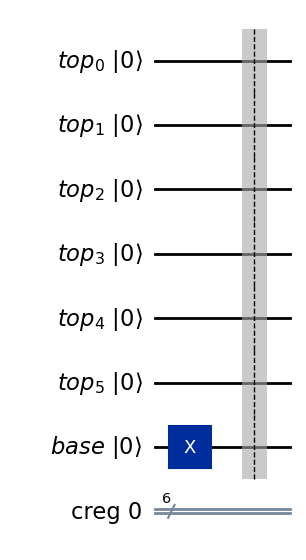

In [11]:
circuit.draw(initial_state=True, output="mpl")

### Step 2: Hadamard Gates
    Next, we need to apply the Hadamard Gate to all qubits in both registers

In [12]:
circuit.h(top)
circuit.h(base)

We add a barrier to keep this step separate

In [13]:
circuit.barrier(top,base)

The circuit after this stage

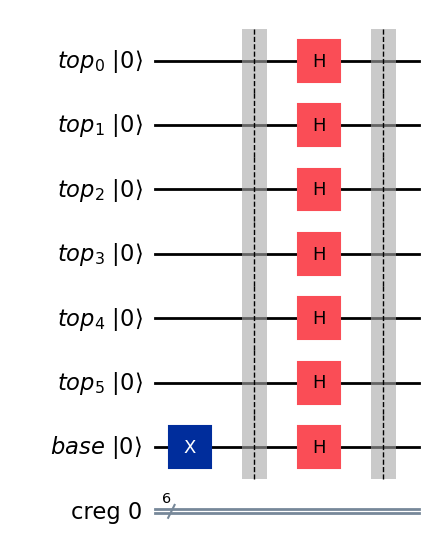

In [14]:
circuit.draw(initial_state=True, output="mpl")

### Step 3: Applying the Oracle
    We then apply the oracle

In [15]:
oracle = oracleGen(n)
circuit.append(oracle, range(n+1))

We add a barrier to keep this step separate

In [16]:
circuit.barrier(top,base)

The circuit after this stage

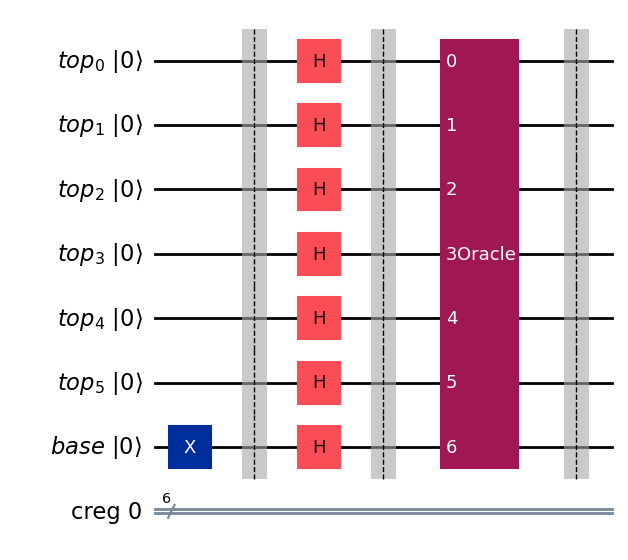

In [17]:
circuit.draw(initial_state=True, output="mpl")

### Step 4: Hadamard Gates
    We then apply Hadamard Gates to all qubits in the top register

In [18]:
circuit.h(top)

We add a barrier to keep this step separate

In [19]:
circuit.barrier(top,base)

The circuit after this stage

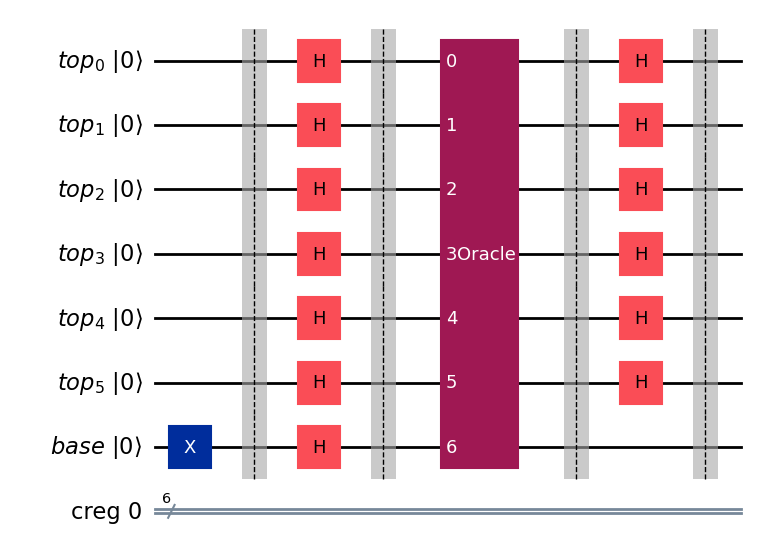

In [20]:
circuit.draw(initial_state=True, output="mpl")

### Step 5: Measurement
We now measure the top register to the classical register

In [21]:
circuit.measure(top, creg)

The circuit after this stage

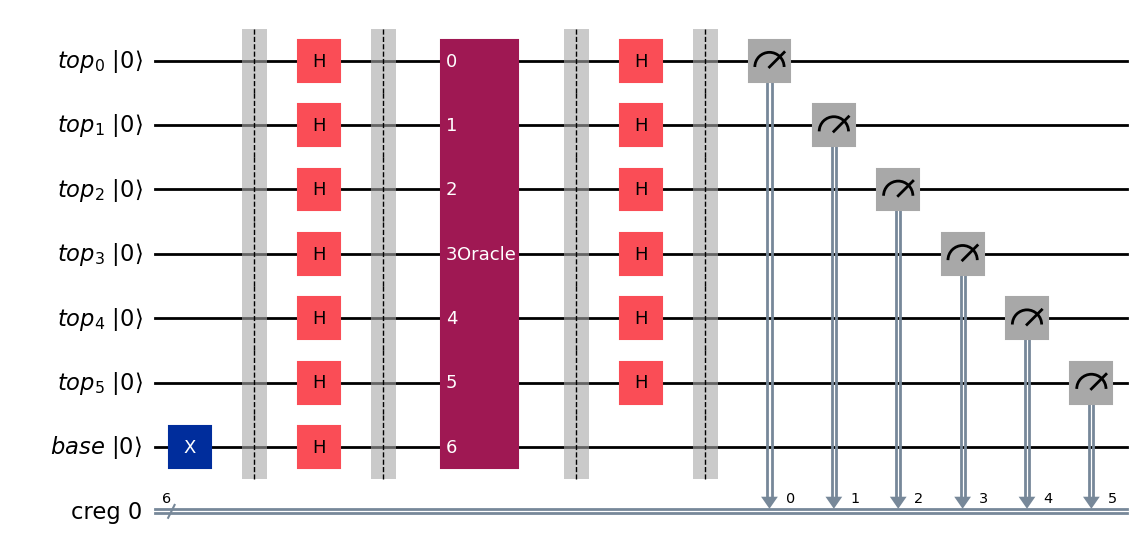

In [22]:
circuit.draw(initial_state=True, output="mpl")

## Execute
We now run the algorithm.

*This implementation does not implement noise, so one shot would be sufficient, but 1024 are still used*

### Make a copy of the setup

In [23]:
circ = circuit.copy()

### Define which simulator to use

In [24]:
aersim = AerSimulator()

### We then transpile this copy

In [25]:
circTranspiled = transpile(circ,aersim)

### Run in the Qiskit Aer Simulator

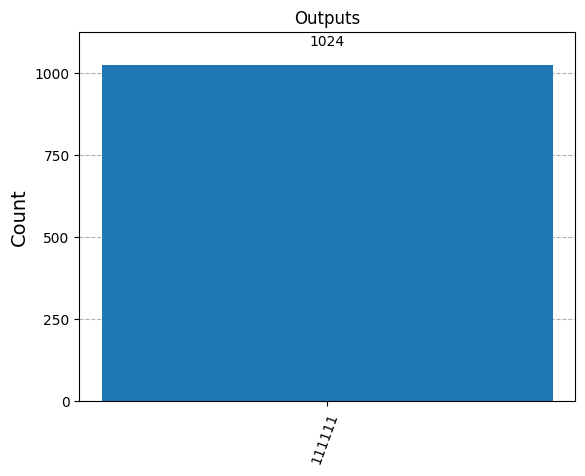

In [26]:
result_ideal = aersim.run(circTranspiled, shots=1024).result()
counts_ideal = result_ideal.get_counts(0)
plot_histogram(counts_ideal, title='Outputs')

## Interpeting
We now proccess the outputs

We want to interpret the state with the greatest count

The counts come out in the form of a dictionary with the measured states as the keys

In [27]:
print(counts_ideal)

{'111111': 1024}


### Swap keys and counts
Since we want to sort by count and not by key, we flip the two

In [28]:
swapped = [(value, key) for key, value in counts_ideal.items()]
print(swapped)

[(1024, '111111')]


### Sort and record the state

In [29]:
endState = max(swapped)[1]
print(endState)

111111


### Check whether this is the state for a constant or balanced oracle
If it is constant, it will be all 0s

If it is balanced, it will be all 1s

Thus, it is sufficient to check the last digit

In [30]:
if ((int(endState) % 10) == 0):
    oracleType = "constant"
else:
    oracleType = "balanced"

## Final Result

In [31]:
print("This time, the function f(x) was "+oracleType+".")

This time, the function f(x) was balanced.
